In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Carregar os dados
df = pd.read_csv('btc_usdt_1min_data.csv')

# Converter o timestamp para datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Ordenar os dados pelo timestamp
df = df.sort_values('timestamp')

# Converter o timestamp para um formato numérico
df['timestamp_numeric'] = df['timestamp'].astype(int) / 10**9  # Converter para segundos desde o Epoch

# Aplicar uma média móvel de 10 períodos para suavizar os dados
df['close_smooth'] = df['close'].rolling(window=10).mean()

# Remover linhas com NaN resultantes da média móvel
df = df.dropna(subset=['close_smooth'])

# Usar o timestamp como variável independente
X = df[['timestamp_numeric']]
y = df['close_smooth']

# Separar os dados em treino e teste de forma aleatória
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar o modelo de regressão linear
reg = LinearRegression()

# Ajustar o modelo aos dados de treino
reg.fit(X_train, y_train)

# Fazer previsões nos dados de teste
y_pred = reg.predict(X_test)

# Plotar os resultados
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', alpha=0.5, label='Valores Reais')
plt.scatter(X_test, y_pred, color='red', alpha=0.5, label='Previsões')
plt.plot(X_test, y_pred, color='red', alpha=0.7)

# Labels e título
plt.xlabel('Timestamp (em segundos)', fontsize=12)
plt.ylabel('Preço Fechamento (USD)', fontsize=12)
plt.title('Regressão Linear usando Timestamp como Série Temporal', fontsize=14)
plt.legend()

# Adicionar grade
plt.grid(True)

# Exibir o gráfico
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'btc_usdt_1min_data.csv'

In [ ]:
df

,timestamp,open,high,low,close,volume,timestamp_numeric,close_smooth
9,2024-01-01 00:09:00,42420.06,42420.07,42403.99,42409.96,26.40178,1.704068e+09,42378.696
10,2024-01-01 00:10:00,42409.97,42440.06,42409.96,42440.05,22.61788,1.704068e+09,42392.840
11,2024-01-01 00:11:00,42440.06,42480.68,42440.05,42479.32,31.81488,1.704068e+09,42408.772
12,2024-01-01 00:12:00,42479.31,42479.32,42462.22,42462.24,25.25342,1.704068e+09,42422.446
13,2024-01-01 00:13:00,42462.24,42480.16,42460.00,42480.15,21.40862,1.704068e+09,42433.662
...,...,...,...,...,...,...,...,...
338495,2024-08-23 01:35:00,60626.61,60656.92,60626.61,60656.91,3.44265,1.724377e+09,60682.371
338496,2024-08-23 01:36:00,60656.91,60666.84,60649.99,60652.00,7.29454,1.724377e+09,60670.519
338497,2024-08-23 01:37:00,60652.01,60670.00,60652.00,60670.00,6.75587,1.724377e+09,60660.394
338498,2024-08-23 01:38:00,60669.99,60669.99,60652.40,60652.75,3.81661,1.724377e+09,60652.870


Esse código implementa um modelo de previsão de preços utilizando redes neurais recorrentes, especificamente a Long Short-Term Memory (LSTM), que é uma variação da RNN (Recurrent Neural Network) adaptada para capturar dependências de longo prazo em séries temporais.



Aqui, o modelo LSTM é construído usando a API Sequencial do Keras. Ele consiste em duas camadas LSTM. A primeira retorna sequências (return_sequences=True), permitindo que a segunda camada LSTM possa processar essa sequência. O Dropout é utilizado para prevenir overfitting, desligando aleatoriamente 20% dos neurônios durante o treinamento. A última camada é uma camada densa (fully connected) que reduz a saída para um único valor, que será o preço previsto.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Pré-processamento
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))

# Dividir dados em treino e teste
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Criar janelas de dados para LSTM
def create_dataset(data, look_back=60):
    X, Y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)

look_back = 10
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Reshape para [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Criar modelo LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar modelo
model.fit(X_train, y_train, epochs=1, batch_size=64)

# Fazer previsões
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
# Transformar y_test de volta à escala original
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calcular RMSE
rmse = np.sqrt(np.mean((predicted_prices - y_test_scaled)**2))
print(f'RMSE: {rmse}')



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4231/4231 ━━━━━━━━━━━━━━━━━━━━ 71s 16ms/step - loss: 0.0057
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step


In [ ]:
# Transformar y_test de volta à escala original
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calcular RMSE
rmse = np.sqrt(np.mean((predicted_prices - y_test_scaled)**2))
print(f'RMSE: {rmse}')



RMSE: 177.50843243534032


<ipython-input-6-322aeeceb300>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predicted_prices


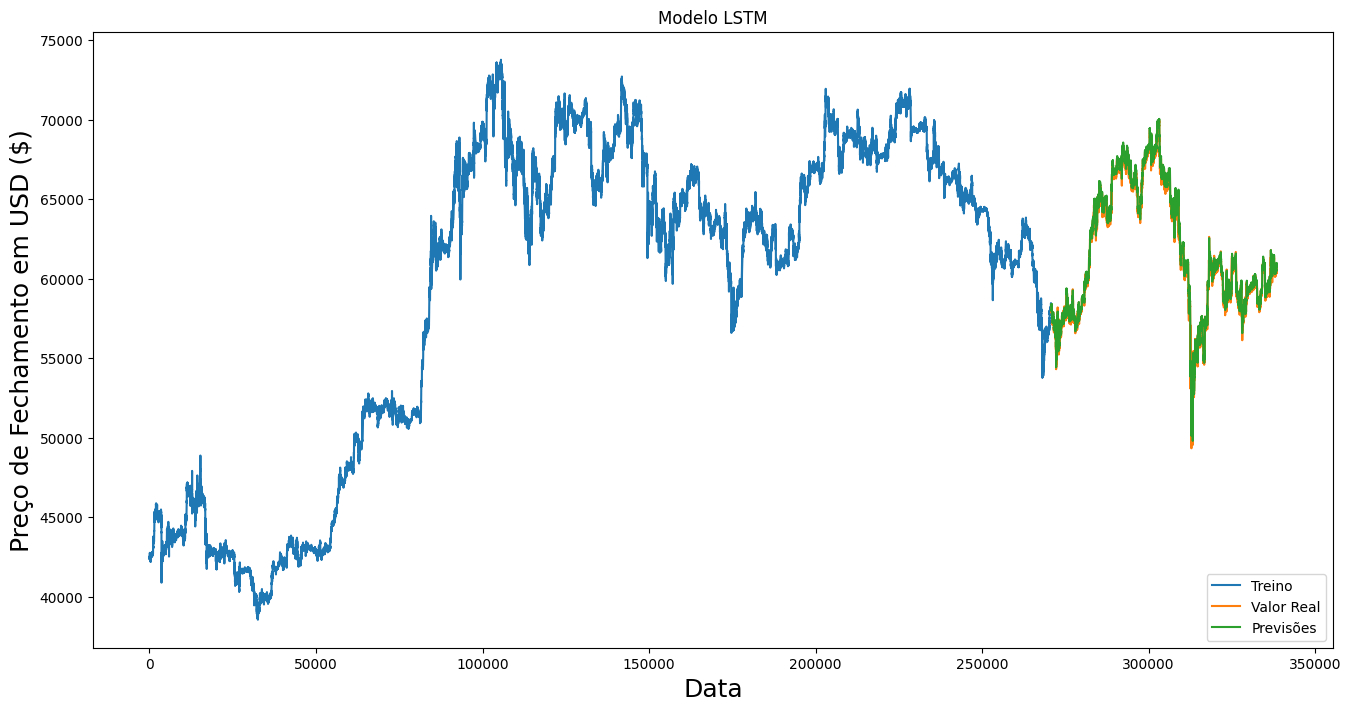

In [ ]:
# Ajustar o comprimento de valid para coincidir com o de predicted_prices
valid = df[train_size + look_back:]  # Subtraindo look_back para ajustar o comprimento
valid['Predictions'] = predicted_prices

# Visualizar os dados
plt.figure(figsize=(16,8))
plt.title('Modelo LSTM')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Preço de Fechamento em USD ($)', fontsize=18)
plt.plot(train['close'], label='Treino')
plt.plot(valid['close'], label='Valor Real')
plt.plot(valid['Predictions'], label='Previsões')
plt.legend(['Treino', 'Valor Real', 'Previsões'], loc='lower right')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

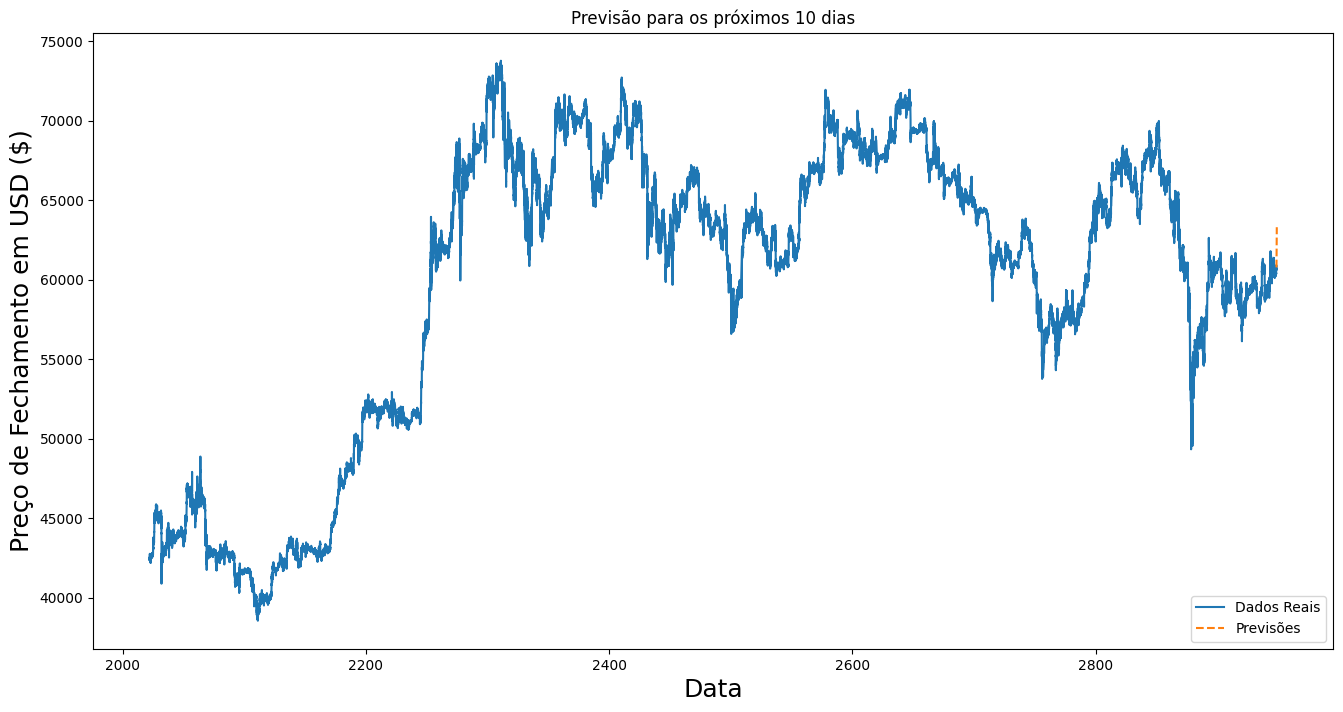

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Número de dias para prever
forecast_days = 100

# Preparar a lista para armazenar as previsões
forecast = []

# Usar os últimos 'look_back' dias do dataset de teste para começar as previsões
current_input = test_data[-look_back:].reshape(1, look_back, 1)

for _ in range(forecast_days):
    # Fazer a previsão para o próximo dia
    next_pred = model.predict(current_input)

    # Adicionar a previsão à lista de previsões
    forecast.append(next_pred[0, 0])

    # Atualizar o input: remover o primeiro valor e adicionar a nova previsão no final
    next_pred_reshaped = np.reshape(next_pred[0, 0], (1, 1, 1))
    current_input = np.append(current_input[:, 1:, :], next_pred_reshaped, axis=1)

# Transformar as previsões de volta à escala original
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Gerar as datas para as previsões
last_date = df.index[-1]  # última data do conjunto de dados
dates = [last_date + timedelta(days=i+1) for i in range(forecast_days)]

# Criar DataFrame de previsões, usando as datas correspondentes
forecast_df = pd.DataFrame(data=forecast, index=dates, columns=['Predictions'])

# Visualizar as previsões junto com os dados reais
plt.figure(figsize=(16,8))
plt.title('Previsão para os próximos 100 dias')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Preço de Fechamento em USD ($)', fontsize=18)
plt.plot(df['close'], label='Dados Reais')
plt.plot(forecast_df['Predictions'], label='Previsões', linestyle='dashed')
plt.legend(['Dados Reais', 'Previsões'], loc='lower right')
plt.show()


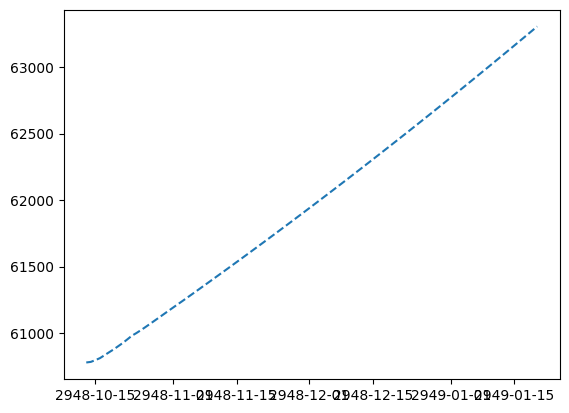

In [ ]:
plt.plot(forecast_df['Predictions'], label='Previsões', linestyle='dashed')

In [ ]:
df.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume'], dtype='object')

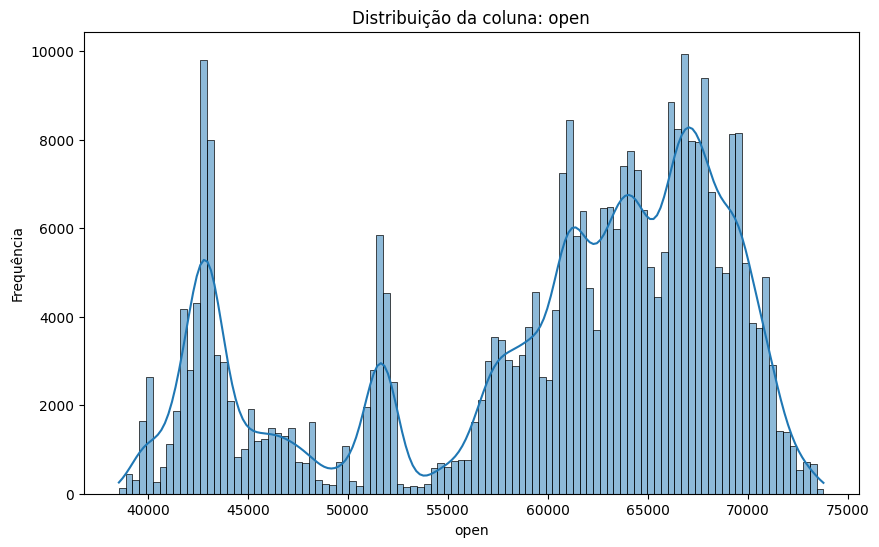

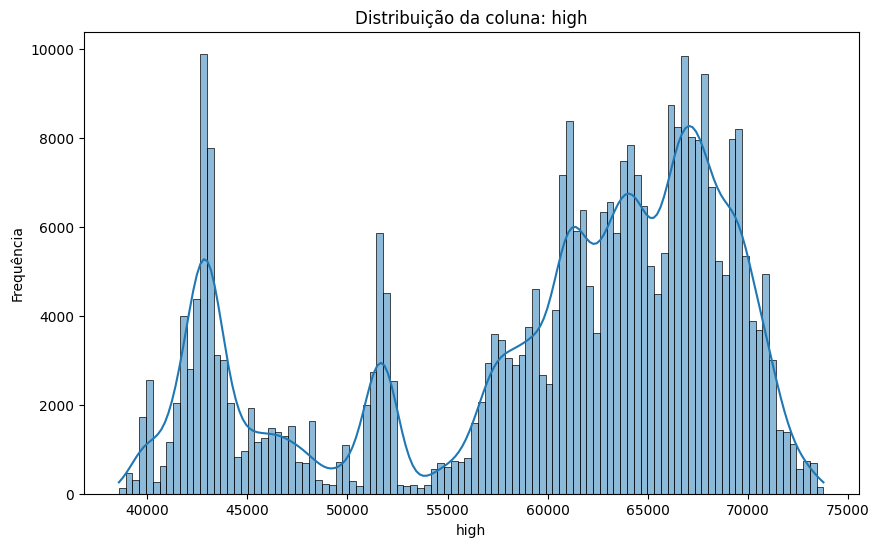

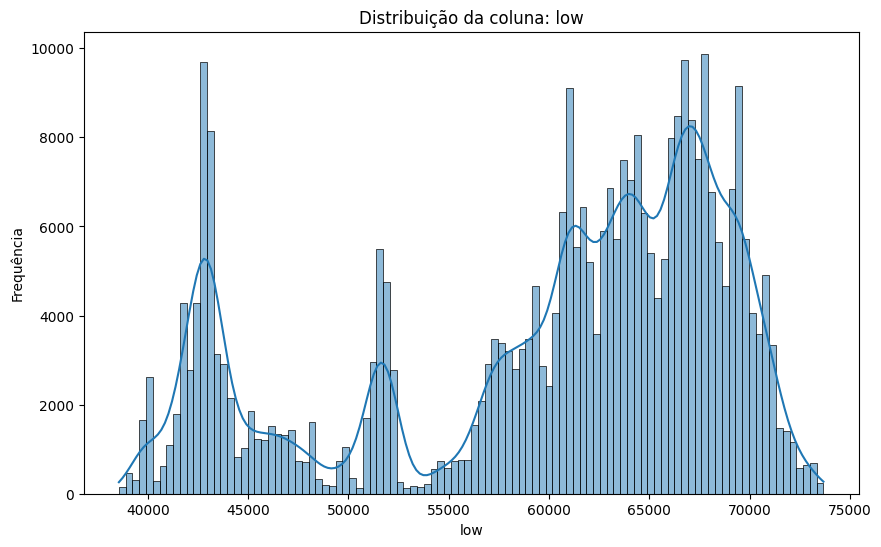

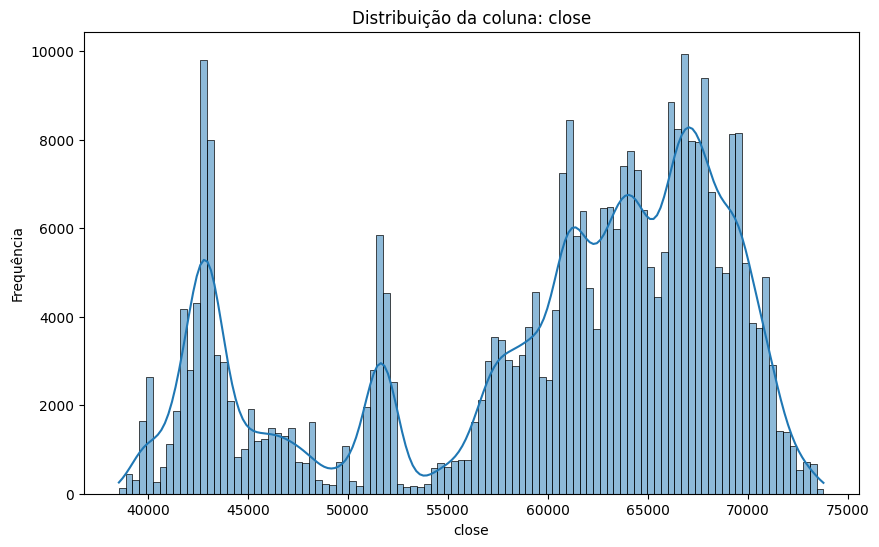

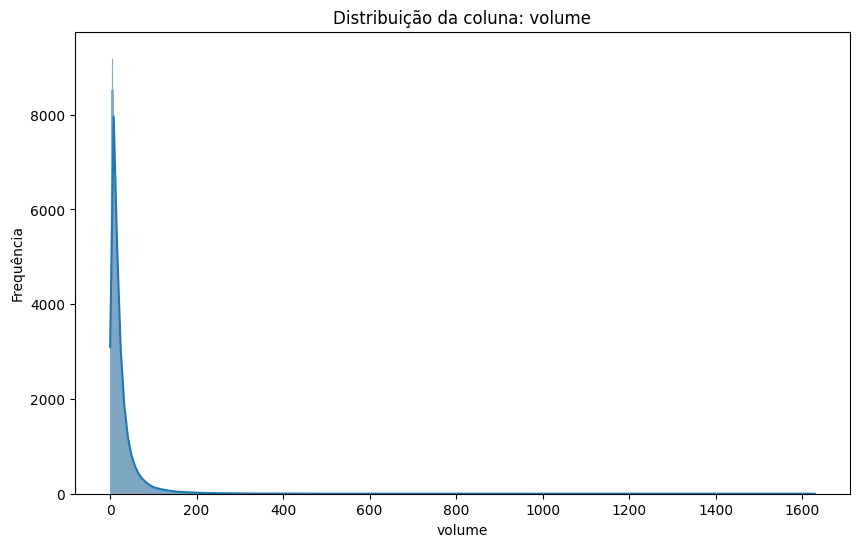

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar os dados
df = pd.read_csv('btc_usdt_1min_data.csv')

# Converter o timestamp para datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Ordenar os dados pelo timestamp
df = df.sort_values('timestamp')

# Selecionar apenas as colunas numéricas
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Criar gráficos de distribuição para cada coluna numérica
for column in numerical_columns:
    plt.figure(figsize=(10, 6))

    # Histograma com KDE
    sns.histplot(df[column], kde=True)

    plt.title(f'Distribuição da coluna: {column}')
    plt.xlabel(column)
    plt.ylabel('Frequência')

    plt.show()


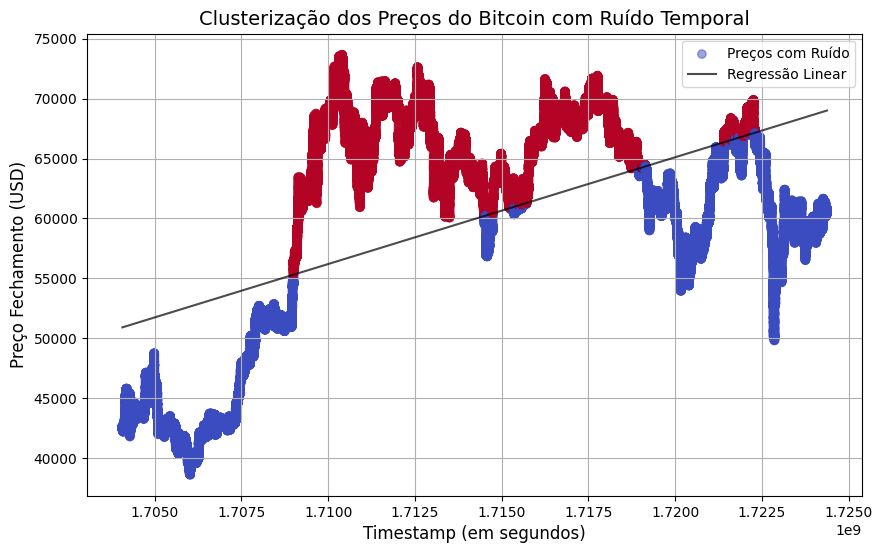

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Carregar os dados
df_real = pd.read_csv('btc_usdt_1min_data.csv')

# Converter o timestamp para datetime
df_real['timestamp'] = pd.to_datetime(df_real['timestamp'])

# Ordenar os dados pelo timestamp
df_real = df_real.sort_values('timestamp')

# Converter o timestamp para um formato numérico
df_real['timestamp_numeric'] = df_real['timestamp'].astype(int) / 10**9  # Converter para segundos desde o Epoch

# Aplicar uma média móvel de 10 períodos para suavizar os dados
df_real['close_smooth'] = df_real['close'].rolling(window=10).mean()

# Remover linhas com NaN resultantes da média móvel
df_real = df_real.dropna(subset=['close_smooth'])

# Calcular o desvio padrão como 1% do intervalo temporal
std_dev_time = 0.01 * (df_real['timestamp_numeric'].max() - df_real['timestamp_numeric'].min())

# Criar uma cópia dos dados reais para adicionar ruído
df_noisy = df_real.copy()

# Adicionar ruído gaussiano para deslocar o timestamp para o ponto médio de intervalos de 30 segundos
np.random.seed(42)  # Para reprodutibilidade
time_noise = np.random.choice([15, -15], size=len(df_noisy))  # Desloca para o meio dos 30 segundos
df_noisy['timestamp_noisy'] = df_noisy['timestamp_numeric'] + time_noise

# Usar o timestamp com ruído como variável independente
X_noisy = df_noisy[['timestamp_noisy']]
y_noisy = df_noisy['close_smooth']

# Criar o modelo de regressão linear
reg = LinearRegression()

# Ajustar o modelo aos dados com ruído
reg.fit(X_noisy, y_noisy)

# Fazer previsões usando o modelo ajustado
df_noisy['price_pred'] = reg.predict(X_noisy)

# Clusterização baseada nos preços acima e abaixo da linha de regressão
df_noisy['residual'] = df_noisy['close_smooth'] - df_noisy['price_pred']
df_noisy['cluster'] = (df_noisy['residual'] > 0).astype(int)

# Plotar os resultados
plt.figure(figsize=(10, 6))
plt.scatter(df_noisy['timestamp_noisy'], df_noisy['close_smooth'], c=df_noisy['cluster'], cmap='coolwarm', alpha=0.5, label='Preços com Ruído')
plt.plot(df_noisy['timestamp_noisy'], df_noisy['price_pred'], color='black', alpha=0.7, label='Regressão Linear')

# Labels e título
plt.xlabel('Timestamp (em segundos)', fontsize=12)
plt.ylabel('Preço Fechamento (USD)', fontsize=12)
plt.title('Clusterização dos Preços do Bitcoin com Ruído Temporal', fontsize=14)
plt.legend()

# Adicionar grade
plt.grid(True)

# Exibir o gráfico
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg

# Carregar os dados
df_real = pd.read_csv('btc_usdt_1min_data.csv')

# Converter o timestamp para datetime
df_real['timestamp'] = pd.to_datetime(df_real['timestamp'])

# Ordenar os dados pelo timestamp
df_real = df_real.sort_values('timestamp')

# Converter o timestamp para um formato numérico (opcional para análises futuras)
df_real['timestamp_numeric'] = df_real['timestamp'].astype(np.int64) / 10**9  # Converter para segundos desde o Epoch

# Aplicar uma média móvel de 10 períodos para suavizar os dados
df_real['close_smooth'] = df_real['close'].rolling(window=10).mean()

# Remover linhas com NaN resultantes da média móvel
df_real = df_real.dropna(subset=['close_smooth'])

# Reamostrar os dados para intervalos de 30 segundos
df_real_30s = df_real.set_index('timestamp').resample('30S').asfreq().reset_index()

# Definir as colunas a serem preenchidas
columns_to_fill = ['open', 'high', 'low', 'close', 'volume']

# Interpolação Linear para preencher NaNs garantindo que os valores estejam entre os limites adjacentes
df_real_30s[columns_to_fill] = df_real_30s[columns_to_fill].interpolate(method='linear')

# Agora, incorporar autocorrelação adicionando ruído autocorrelacionado aos valores interpolados
np.random.seed(42)  # Para reprodutibilidade

for column in columns_to_fill:
    # Extrair a série de dados interpolados
    series = df_real_30s[column].copy()

    # Ajustar um modelo autoregressivo (AR) para capturar a autocorrelação
    # Escolher lags apropriados; aqui usamos lag=1
    try:
        model_ar = AutoReg(series.dropna(), lags=1, old_names=False)
        model_fit = model_ar.fit()
    except Exception as e:
        print(f"Erro ao ajustar o modelo AR para a coluna '{column}': {e}")
        continue

    # Obter os resíduos do modelo AR
    residuals = model_fit.resid

    # Gerar ruído autocorrelacionado baseado nos resíduos
    residuals_normalized = (residuals - residuals.mean()) / residuals.std()

    # Gerar ruído pequeno baseado nos resíduos normalizados
    noise = residuals_normalized * (series.max() - series.min()) * 0.01  # Escalonar o ruído

    # Adicionar o ruído aos valores interpolados, preservando o primeiro valor
    series_noisy = series + noise
    series_noisy.iloc[0] = series.iloc[0]  # Garantir que o primeiro valor não seja alterado

    # Garantir que os valores ajustados estejam dentro dos limites adjacentes
    lower_limits = df_real_30s[column].fillna(method='ffill')
    upper_limits = df_real_30s[column].fillna(method='bfill')

    series_noisy_clipped = np.clip(series_noisy, lower_limits, upper_limits)

    # Atualizar a série no DataFrame
    df_real_30s[column] = series_noisy_clipped
    # Remover as colunas 'timestamp_numeric' e 'close_smooth'
    df_real_30s = df_real_30s.drop(columns=['timestamp_numeric', 'close_smooth'], errors='ignore')

# Exibir o DataFrame resultante
print(df_real_30s)


<ipython-input-25-827e72de5856>:62: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lower_limits = df_real_30s[column].fillna(method='ffill')
<ipython-input-25-827e72de5856>:63: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  upper_limits = df_real_30s[column].fillna(method='bfill')
<ipython-input-25-827e72de5856>:62: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lower_limits = df_real_30s[column].fillna(method='ffill')
<ipython-input-25-827e72de5856>:63: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  upper_limits = df_real_30s[column].fillna(method='bfill')
<ipython-input-25-827e72de5856>:62: FutureWarning: Series.fillna with 'method' is de

                 timestamp       open       high        low      close  \
0      2024-01-01 00:09:00  42420.060  42420.070  42403.990  42409.960   
1      2024-01-01 00:09:30  42415.015  42430.065  42406.975  42425.005   
2      2024-01-01 00:10:00  42409.970  42440.060  42409.960  42440.050   
3      2024-01-01 00:10:30  42425.015  42460.370  42425.005  42459.685   
4      2024-01-01 00:11:00  42440.060  42480.680  42440.050  42479.320   
...                    ...        ...        ...        ...        ...   
676976 2024-08-23 01:37:00  60652.010  60670.000  60652.000  60670.000   
676977 2024-08-23 01:37:30  60661.000  60669.995  60652.200  60661.375   
676978 2024-08-23 01:38:00  60669.990  60669.990  60652.400  60652.750   
676979 2024-08-23 01:38:30  60661.365  60667.000  60652.570  60658.375   
676980 2024-08-23 01:39:00  60652.740  60664.010  60652.740  60664.000   

           volume  
0       26.401780  
1       24.509830  
2       22.617880  
3       27.216380  
4       31.

<ipython-input-25-827e72de5856>:62: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lower_limits = df_real_30s[column].fillna(method='ffill')
<ipython-input-25-827e72de5856>:63: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  upper_limits = df_real_30s[column].fillna(method='bfill')


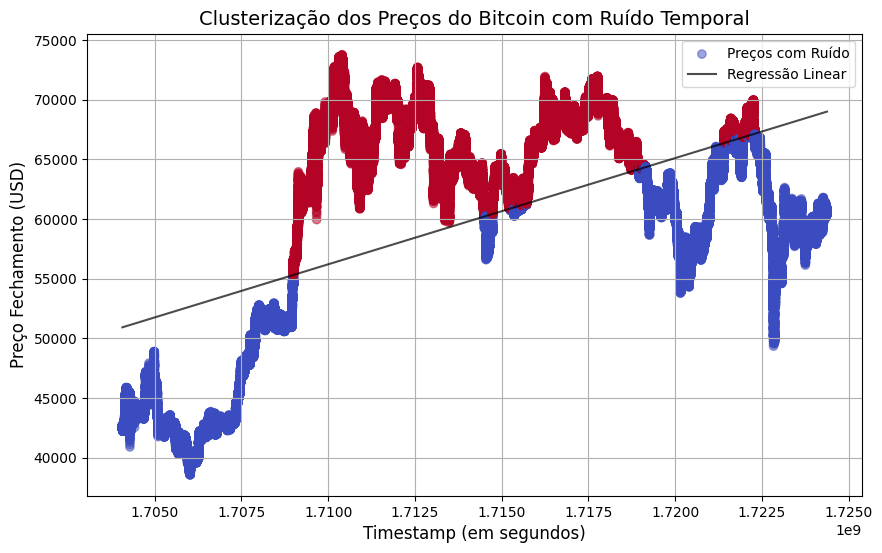

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Considerando que já temos o df_real_30s disponível, vamos diretamente para a adição de ruído e regressão

# Calcular o desvio padrão como 1% do intervalo temporal no df_real_30s
df_real_30s['timestamp_numeric'] = df_real_30s['timestamp'].astype(int) / 10**9  # Converter para segundos desde o Epoch
std_dev_time = 0.01 * (df_real_30s['timestamp_numeric'].max() - df_real_30s['timestamp_numeric'].min())

# Criar uma cópia dos dados reais para adicionar ruído
df_noisy = df_real_30s.copy()

# Adicionar ruído gaussiano para deslocar o timestamp para o ponto médio de intervalos de 30 segundos
np.random.seed(42)  # Para reprodutibilidade
time_noise = np.random.choice([15, -15], size=len(df_noisy))  # Desloca para o meio dos 30 segundos
df_noisy['timestamp_noisy'] = df_noisy['timestamp_numeric'] + time_noise

# Usar o timestamp com ruído como variável independente
X_noisy = df_noisy[['timestamp_noisy']]
y_noisy = df_noisy['close']  # Usando 'close' diretamente já que 'close_smooth' foi removido

# Criar o modelo de regressão linear
reg = LinearRegression()

# Ajustar o modelo aos dados com ruído
reg.fit(X_noisy, y_noisy)

# Fazer previsões usando o modelo ajustado
df_noisy['price_pred'] = reg.predict(X_noisy)

# Clusterização baseada nos preços acima e abaixo da linha de regressão
df_noisy['residual'] = df_noisy['close'] - df_noisy['price_pred']
df_noisy['cluster'] = (df_noisy['residual'] > 0).astype(int)

# Plotar os resultados
plt.figure(figsize=(10, 6))
plt.scatter(df_noisy['timestamp_noisy'], df_noisy['close'], c=df_noisy['cluster'], cmap='coolwarm', alpha=0.5, label='Preços com Ruído')
plt.plot(df_noisy['timestamp_noisy'], df_noisy['price_pred'], color='black', alpha=0.7, label='Regressão Linear')

# Labels e título
plt.xlabel('Timestamp (em segundos)', fontsize=12)
plt.ylabel('Preço Fechamento (USD)', fontsize=12)
plt.title('Clusterização dos Preços do Bitcoin com Ruído Temporal', fontsize=14)
plt.legend()

# Adicionar grade
plt.grid(True)

# Exibir o gráfico
plt.show()


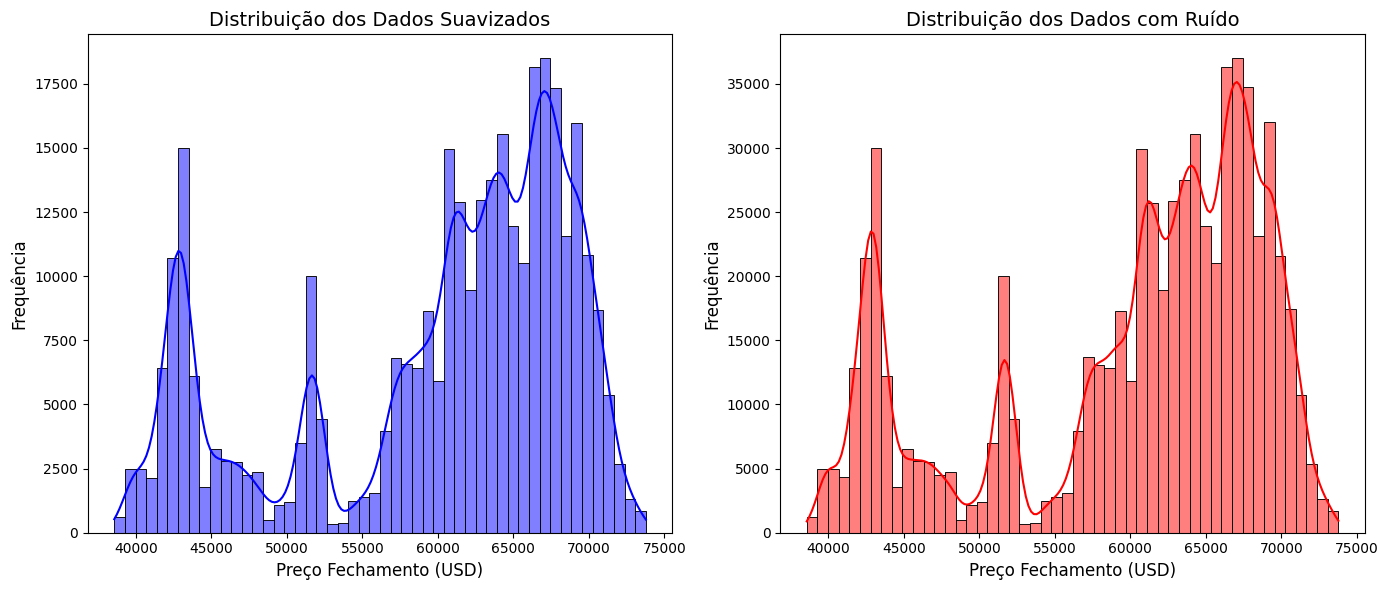

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar o layout para dois gráficos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plotar a distribuição dos dados originais 'close_smooth'
sns.histplot(df['close'], color='blue', kde=True, ax=axes[0], bins=50)
axes[0].set_title('Distribuição dos Dados Suavizados', fontsize=14)
axes[0].set_xlabel('Preço Fechamento (USD)', fontsize=12)
axes[0].set_ylabel('Frequência', fontsize=12)

# Plotar a distribuição dos dados com ruído 'close_noisy'
sns.histplot(df_real_30s['close'], color='red', kde=True, ax=axes[1], bins=50)
axes[1].set_title('Distribuição dos Dados com Ruído', fontsize=14)
axes[1].set_xlabel('Preço Fechamento (USD)', fontsize=12)
axes[1].set_ylabel('Frequência', fontsize=12)

# Ajustar o layout
plt.tight_layout()

# Exibir os gráficos
plt.show()


In [ ]:
df['close']

,close
0,42298.61
1,42320.00
2,42325.50
3,42367.99
4,42397.23
...,...
338495,60656.91
338496,60652.00
338497,60670.00
338498,60652.75


In [ ]:
df_real_30s

,timestamp,open,high,low,close,volume,timestamp_numeric
0,2024-01-01 00:09:00,42420.060,42420.070,42403.990,42409.960,26.401780,1.704068e+09
1,2024-01-01 00:09:30,42415.015,42430.065,42406.975,42425.005,24.509830,1.704068e+09
2,2024-01-01 00:10:00,42409.970,42440.060,42409.960,42440.050,22.617880,1.704068e+09
3,2024-01-01 00:10:30,42425.015,42460.370,42425.005,42459.685,27.216380,1.704068e+09
4,2024-01-01 00:11:00,42440.060,42480.680,42440.050,42479.320,31.814880,1.704068e+09
...,...,...,...,...,...,...,...
676976,2024-08-23 01:37:00,60652.010,60670.000,60652.000,60670.000,6.755870,1.724377e+09
676977,2024-08-23 01:37:30,60661.000,60669.995,60652.200,60661.375,5.286240,1.724377e+09
676978,2024-08-23 01:38:00,60669.990,60669.990,60652.400,60652.750,3.816610,1.724377e+09
676979,2024-08-23 01:38:30,60661.365,60667.000,60652.570,60658.375,2.843965,1.724377e+09


# Treinando dados com ruído

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Pré-processamento
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_real_30s['close'].values.reshape(-1, 1))

# Dividir dados em treino e teste
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Criar janelas de dados para LSTM
def create_dataset(data, look_back=60):
    X, Y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)

look_back = 10
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Reshape para [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Criar modelo LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar modelo
model.fit(X_train, y_train, epochs=1, batch_size=64)

# Fazer previsões
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
# Transformar y_test de volta à escala original
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calcular RMSE
rmse = np.sqrt(np.mean((predicted_prices - y_test_scaled)**2))
print(f'RMSE: {rmse}')



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8463/8463 ━━━━━━━━━━━━━━━━━━━━ 162s 18ms/step - loss: 0.0037
4231/4231 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step
RMSE: 143.4736390504665


<ipython-input-27-f811fb655674>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predicted_prices


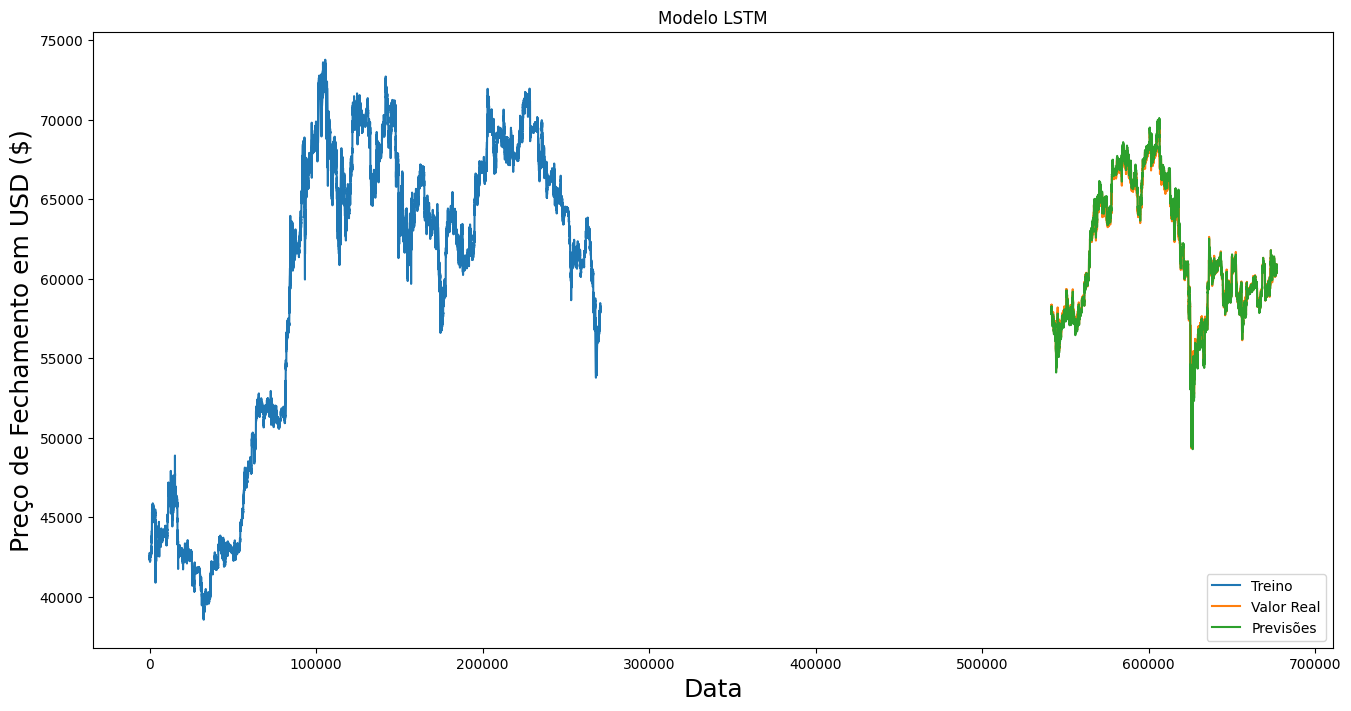

In [ ]:
# Ajustar o comprimento de valid para coincidir com o de predicted_prices
valid = df_real_30s[train_size + look_back:]  # Subtraindo look_back para ajustar o comprimento
valid['Predictions'] = predicted_prices

# Visualizar os dados
plt.figure(figsize=(16,8))
plt.title('Modelo LSTM')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Preço de Fechamento em USD ($)', fontsize=18)
plt.plot(train['close'], label='Treino')
plt.plot(valid['close'], label='Valor Real')
plt.plot(valid['Predictions'], label='Previsões')
plt.legend(['Treino', 'Valor Real', 'Previsões'], loc='lower right')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

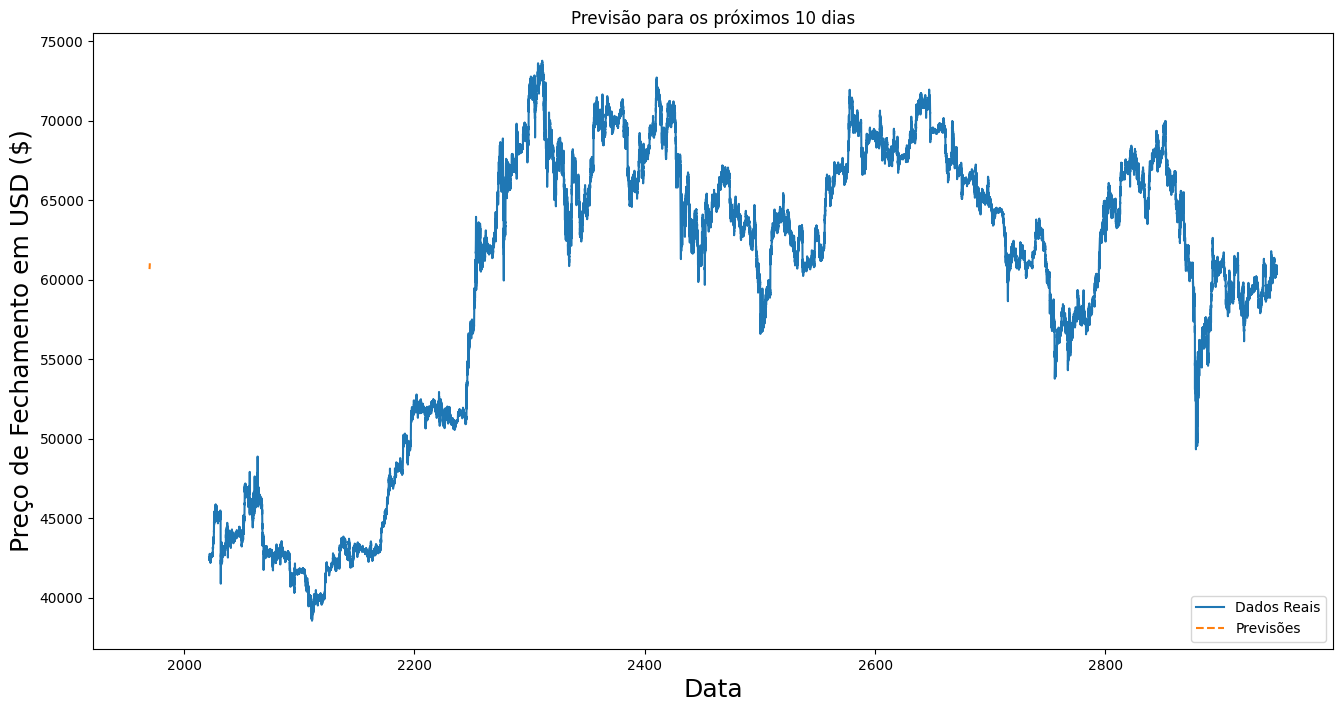

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Número de dias para prever
forecast_days = 100

# Preparar a lista para armazenar as previsões
forecast = []

# Usar os últimos 'look_back' dias do dataset de teste para começar as previsões
current_input = test_data[-look_back:].reshape(1, look_back, 1)

for _ in range(forecast_days):
    # Fazer a previsão para o próximo dia
    next_pred = model.predict(current_input)

    # Adicionar a previsão à lista de previsões
    forecast.append(next_pred[0, 0])

    # Atualizar o input: remover o primeiro valor e adicionar a nova previsão no final
    next_pred_reshaped = np.reshape(next_pred[0, 0], (1, 1, 1))
    current_input = np.append(current_input[:, 1:, :], next_pred_reshaped, axis=1)

# Transformar as previsões de volta à escala original
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
df_real_30s.index = pd.to_datetime(df_real_30s.index)
# Gerar as datas para as previsões
last_date = df_real_30s.index[-1]
# Garantir que o índice do DataFrame seja do tipo datetime


# Agora você pode gerar as datas de previsão
last_date = df_real_30s.index[-1]
dates = [last_date + timedelta(days=i+1) for i in range(forecast_days)] # última data do conjunto de dados
dates = [last_date + timedelta(days=i+1) for i in range(forecast_days)]

# Criar DataFrame de previsões, usando as datas correspondentes
forecast_df = pd.DataFrame(data=forecast, index=dates, columns=['Predictions'])

# Visualizar as previsões junto com os dados reais
plt.figure(figsize=(16,8))
plt.title('Previsão para os próximos 10 dias')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Preço de Fechamento em USD ($)', fontsize=18)
plt.plot(df['close'], label='Dados Reais')
plt.plot(forecast_df['Predictions'], label='Previsões', linestyle='dashed')
plt.legend(['Dados Reais', 'Previsões'], loc='lower right')
plt.show()


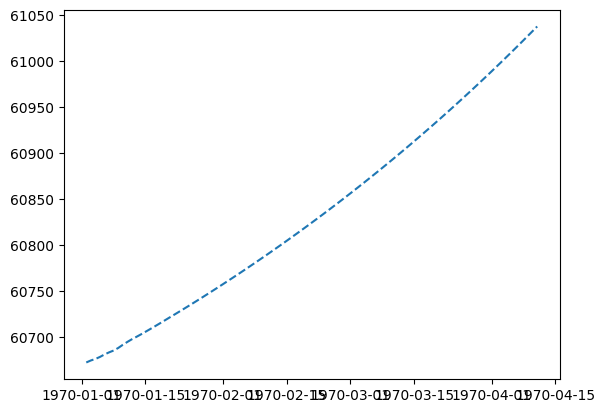

In [ ]:
plt.plot(forecast_df['Predictions'], label='Previsões', linestyle='dashed')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Supondo que você tenha um DataFrame df com as colunas ['timestamp', 'close']

# 1. Calcular o retorno logarítmico
df['log_return'] = np.log(df['close'] / df['close'].shift(1))

# 2. Calcular a volatilidade usando uma média móvel de 30 períodos
df['volatility'] = df['log_return'].rolling(window=30).std()

# 3. Calcular a direcionalidade usando uma média móvel de 50 períodos
df['direction'] = df['close'].diff().rolling(window=50).mean()

# Remover NaN
df = df.dropna()

# 4. Selecionar os features para o clustering
features = df[['log_return', 'volatility', 'direction']]

# 5. Normalizar os features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


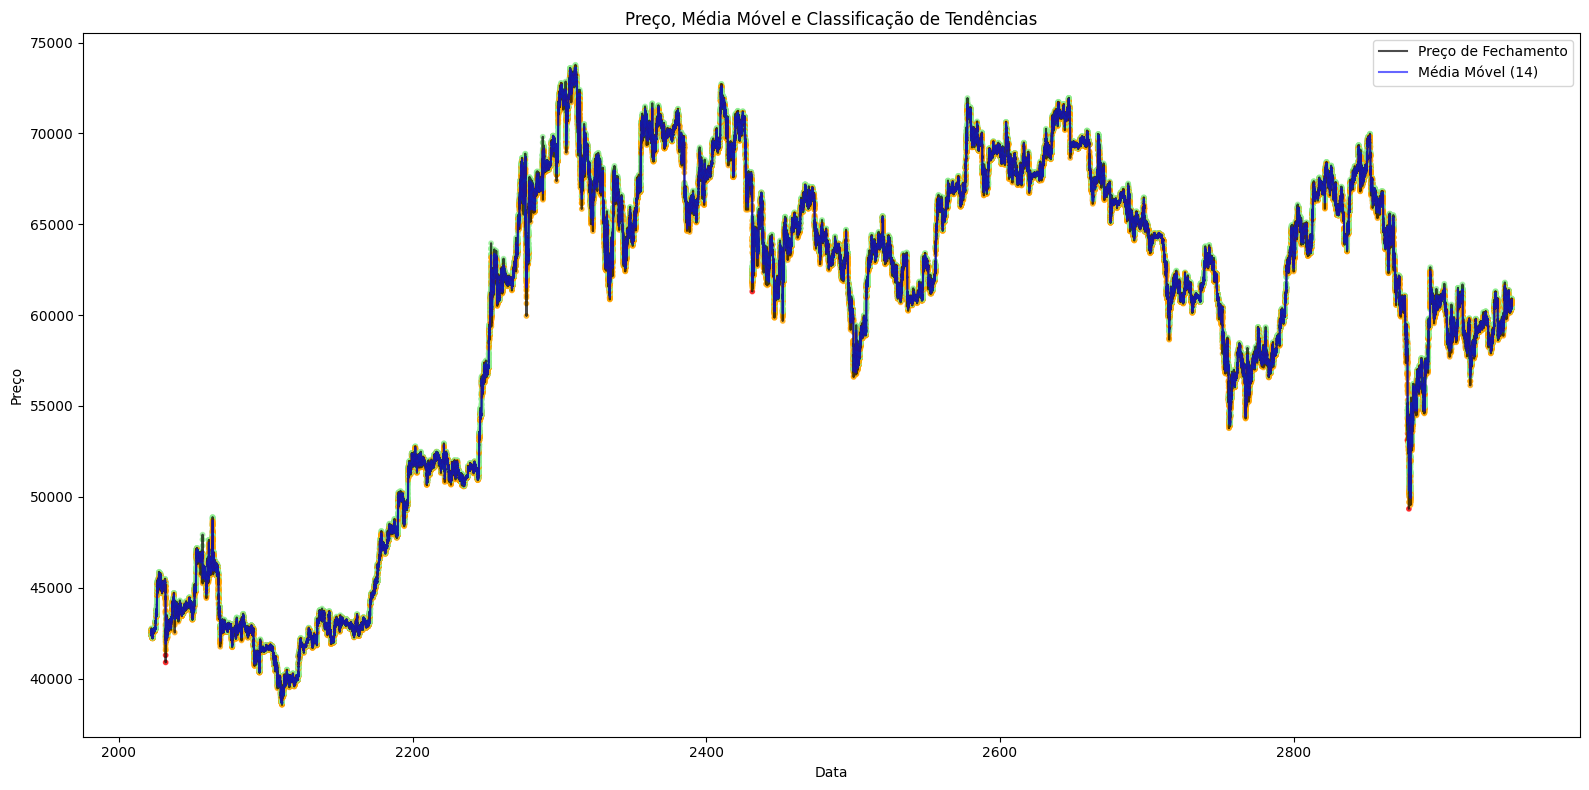


Distribuição das Classificações de Mercado:
Market_State
Tendência de Alta Fraca     0.504675
Tendência de Baixa Fraca    0.495198
Lateralidade                0.000095
Tendência de Baixa Forte    0.000030
Tendência de Alta Forte     0.000003
Name: proportion, dtype: float64

Duração Média das Tendências:
first
Lateralidade                3.555556
Tendência de Alta Forte     1.000000
Tendência de Alta Fraca     7.001721
Tendência de Baixa Forte    2.000000
Tendência de Baixa Fraca    6.868828
Name: count, dtype: float64


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_moving_average_deviation(df, price_col='close', window=20):
    df['MA'] = df[price_col].rolling(window=window).mean()
    df['Deviation'] = (df[price_col] - df['MA']) / df['MA']
    return df, window  # Retorna o tamanho da janela junto com o DataFrame

def classify_market(df, deviation_col='Deviation', threshold_high=0.03, threshold_low=-0.03):
    conditions = [
        (df[deviation_col] > threshold_high),
        (df[deviation_col] > 0) & (df[deviation_col] <= threshold_high),
        (df[deviation_col] < 0) & (df[deviation_col] >= threshold_low),
        (df[deviation_col] < threshold_low)
    ]
    choices = ['Tendência de Alta Forte', 'Tendência de Alta Fraca',
               'Tendência de Baixa Fraca', 'Tendência de Baixa Forte']
    df['Market_State'] = np.select(conditions, choices, default='Lateralidade')
    return df

def plot_price_with_trends(df, price_col='close', state_col='Market_State', window=14):
    colors = {
        'Tendência de Alta Forte': 'darkgreen',
        'Tendência de Alta Fraca': 'lightgreen',
        'Lateralidade': 'yellow',
        'Tendência de Baixa Fraca': 'orange',
        'Tendência de Baixa Forte': 'red'
    }

    plt.figure(figsize=(16, 8))
    plt.plot(df.index, df[price_col], label='Preço de Fechamento', color='black', alpha=0.7)
    plt.plot(df.index, df['MA'], label=f'Média Móvel ({window})', color='blue', alpha=0.6)
    plt.scatter(df.index, df[price_col], c=df[state_col].map(colors), alpha=0.7, s=10)
    plt.title('Preço, Média Móvel e Classificação de Tendências')
    plt.xlabel('Data')
    plt.ylabel('Preço')
    plt.legend()
    plt.tight_layout()
    plt.show()

def main(df, price_col='close', window=14, threshold_high=0.03, threshold_low=-0.03):
    df, window = calculate_moving_average_deviation(df, price_col, window)
    df = classify_market(df, 'Deviation', threshold_high, threshold_low)
    plot_price_with_trends(df, price_col, window=window)

    # Print summary statistics
    print("\nDistribuição das Classificações de Mercado:")
    print(df['Market_State'].value_counts(normalize=True))

    # Calculate trend durations
    df['Trend_Change'] = df['Market_State'].ne(df['Market_State'].shift())
    trend_durations = df.groupby((df['Trend_Change'].cumsum()))['Market_State'].agg(['first', 'count'])
    print("\nDuração Média das Tendências:")
    print(trend_durations.groupby('first')['count'].mean())

# Exemplo de chamada da função main
if __name__ == "__main__":
    # Substitua `df` pelo seu DataFrame contendo os dados
    # Certifique-se de que o DataFrame tenha um índice de data/hora e uma coluna 'close'
    main(df)

In [ ]:
df['Market_State']

,Market_State
2022-01-10 00:00:00,Lateralidade
2022-01-11 00:00:00,Lateralidade
2022-01-12 00:00:00,Lateralidade
2022-01-13 00:00:00,Lateralidade
2022-01-14 00:00:00,Lateralidade
...,...
2948-10-08 00:00:00,Tendência de Baixa Fraca
2948-10-09 00:00:00,Tendência de Baixa Fraca
2948-10-10 00:00:00,Tendência de Baixa Fraca
2948-10-11 00:00:00,Tendência de Baixa Fraca


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
4230/4230 ━━━━━━━━━━━━━━━━━━━━ 357s 84ms/step - accuracy: 0.9049 - loss: 0.2897 - val_accuracy: 0.9289 - val_loss: 0.2437
Epoch 2/10
4230/4230 ━━━━━━━━━━━━━━━━━━━━ 403s 89ms/step - accuracy: 0.9302 - loss: 0.2362 - val_accuracy: 0.9290 - val_loss: 0.2340
Epoch 3/10
4230/4230 ━━━━━━━━━━━━━━━━━━━━ 351s 83ms/step - accuracy: 0.9320 - loss: 0.2293 - val_accuracy: 0.9290 - val_loss: 0.2339
Epoch 4/10
4230/4230 ━━━━━━━━━━━━━━━━━━━━ 378s 82ms/step - accuracy: 0.9316 - loss: 0.2303 - val_accuracy: 0.9291 - val_loss: 0.2331
Epoch 5/10
4230/4230 ━━━━━━━━━━━━━━━━━━━━ 400s 86ms/step - accuracy: 0.9305 - loss: 0.2312 - val_accuracy: 0.9290 - val_loss: 0.2332
Epoch 6/10
4230/4230 ━━━━━━━━━━━━━━━━━━━━ 362s 82ms/step - accuracy: 0.9315 - loss: 0.2291 - val_accuracy: 0.9288 - val_loss: 0.2337
Epoch 7/10
4230/4230 ━━━━━━━━━━━━━━━━━━━━ 376s 80ms/step - accuracy: 0.9311 - loss: 0.2297 - val_accuracy: 0.9291 - val_loss: 0.2321
Epoch 8/10
4230/4230 ━━━━━━━━━━━━━━━━━━━━ 385s 81ms/step - accuracy: 

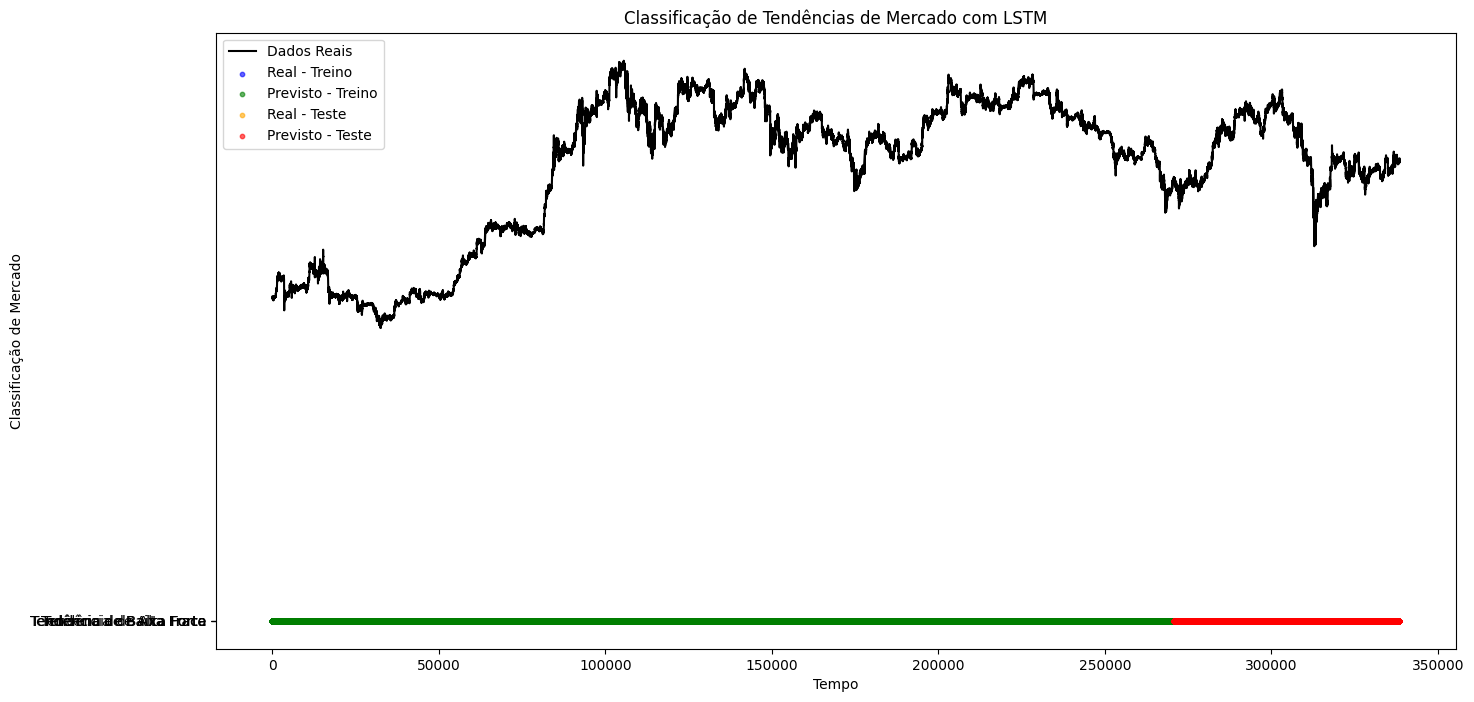

Train Accuracy: 0.93
Test Accuracy: 0.93


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.initializers import Orthogonal
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def create_dataset(df, look_back=20):
    X, y = [], []
    for i in range(len(df) - look_back):
        X.append(df[i:(i + look_back), 0])
        y.append(df[i + look_back])
    return np.array(X), np.array(y)

def boris_hanin_init(shape, dtype=None):
    n_in, n_out = shape
    variance = 2 / (n_in + n_out)
    return tf.keras.backend.random_normal(shape, mean=0., stddev=np.sqrt(variance), dtype=dtype)

def create_lstm_model(input_shape, units=50, dropout_rate=0.2, num_classes=5):
    model = Sequential([
        LSTM(units, input_shape=input_shape, return_sequences=True,
             kernel_initializer=boris_hanin_init,
             recurrent_initializer=Orthogonal()),
        Dropout(dropout_rate),
        LSTM(units, return_sequences=False,
             kernel_initializer=boris_hanin_init,
             recurrent_initializer=Orthogonal()),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def classify_trend(deviation, threshold_high=0.03, threshold_low=-0.03):
    if deviation > threshold_high:
        return 'Tendência de Alta Forte'
    elif deviation > 0 and deviation <= threshold_high:
        return 'Tendência de Alta Fraca'
    elif deviation < 0 and deviation >= threshold_low:
        return 'Tendência de Baixa Fraca'
    elif deviation < threshold_low:
        return 'Tendência de Baixa Forte'
    else:
        return 'Lateralidade'

def preprocess_data(df, column='close', look_back=60):
    # Calcula a média móvel e a categorização dos desvios
    df['MA'] = df[column].rolling(window=look_back).mean()
    df['Deviation'] = (df[column] - df['MA']) / df['MA']
    df['Market_State'] = df['Deviation'].apply(classify_trend)

    # Codificar as classes em números inteiros
    label_encoder = LabelEncoder()
    df['Market_State'] = label_encoder.fit_transform(df['Market_State'])

    # Preparar o dataset
    data = df['Market_State'].values
    X, y = create_dataset(data.reshape(-1, 1), look_back)

    # Transformar y em one-hot encoding
    y = to_categorical(y, num_classes=len(label_encoder.classes_))

    # Reshape de X para 3D
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y, label_encoder

def train_and_predict(df, column='close', look_back=20, test_size=0.2, epochs=5, batch_size=64):
    X, y, label_encoder = preprocess_data(df, column, look_back)

    # Dividir em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Criar e treinar o modelo
    model = create_lstm_model((look_back, 1), units=50, dropout_rate=0.2, num_classes=y.shape[1])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

    # Fazer previsões
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    return y_train_pred, y_test_pred, y_train, y_test, history, label_encoder

def plot_results(df, y_train_pred, y_test_pred, y_train, y_test, label_encoder, column='close'):
    import matplotlib.pyplot as plt

    # Obter as classes reais e previstas
    y_train_real = np.argmax(y_train, axis=1)
    y_test_real = np.argmax(y_test, axis=1)
    y_train_pred = np.argmax(y_train_pred, axis=1)
    y_test_pred = np.argmax(y_test_pred, axis=1)

    # Decodificar as classes
    y_train_real_decoded = label_encoder.inverse_transform(y_train_real)
    y_test_real_decoded = label_encoder.inverse_transform(y_test_real)
    y_train_pred_decoded = label_encoder.inverse_transform(y_train_pred)
    y_test_pred_decoded = label_encoder.inverse_transform(y_test_pred)

    # Plotagem dos resultados
    plt.figure(figsize=(16, 8))
    plt.plot(df[column], label='Dados Reais', color='black')
    plt.scatter(range(60, 60 + len(y_train_real_decoded)), y_train_real_decoded, label='Real - Treino', color='blue', alpha=0.6, s=10)
    plt.scatter(range(60, 60 + len(y_train_pred_decoded)), y_train_pred_decoded, label='Previsto - Treino', color='green', alpha=0.6, s=10)
    plt.scatter(range(60 + len(y_train_real_decoded), 60 + len(y_train_real_decoded) + len(y_test_real_decoded)), y_test_real_decoded, label='Real - Teste', color='orange', alpha=0.6, s=10)
    plt.scatter(range(60 + len(y_train_real_decoded), 60 + len(y_train_real_decoded) + len(y_test_pred_decoded)), y_test_pred_decoded, label='Previsto - Teste', color='red', alpha=0.6, s=10)
    plt.title('Classificação de Tendências de Mercado com LSTM')
    plt.xlabel('Tempo')
    plt.ylabel('Classificação de Mercado')
    plt.legend()
    plt.show()

def main(df, column='close'):
    y_train_pred, y_test_pred, y_train, y_test, history, label_encoder = train_and_predict(df, column)
    plot_results(df, y_train_pred, y_test_pred, y_train, y_test, label_encoder, column)

    # Calcular a acurácia
    train_accuracy = np.mean(np.argmax(y_train, axis=1) == np.argmax(y_train_pred, axis=1))
    test_accuracy = np.mean(np.argmax(y_test, axis=1) == np.argmax(y_test_pred, axis=1))
    print(f'Train Accuracy: {train_accuracy:.2f}')
    print(f'Test Accuracy: {test_accuracy:.2f}')

if __name__ == "__main__":
    # Substitua `df` pelo seu DataFrame contendo os dados
    # Certifique-se de que o DataFrame tenha uma coluna 'close' para o preço de fechamento
    main(df)


4231/4231 ━━━━━━━━━━━━━━━━━━━━ 381s 89ms/step - class_output_accuracy: 0.4426 - loss: 3643241728.0000 - price_output_mse: 3643241728.0000 - val_class_output_accuracy: 0.4958 - val_loss: 3785624320.0000 - val_price_output_mse: 3785624320.0000
8461/8461 ━━━━━━━━━━━━━━━━━━━━ 158s 19ms/step
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step


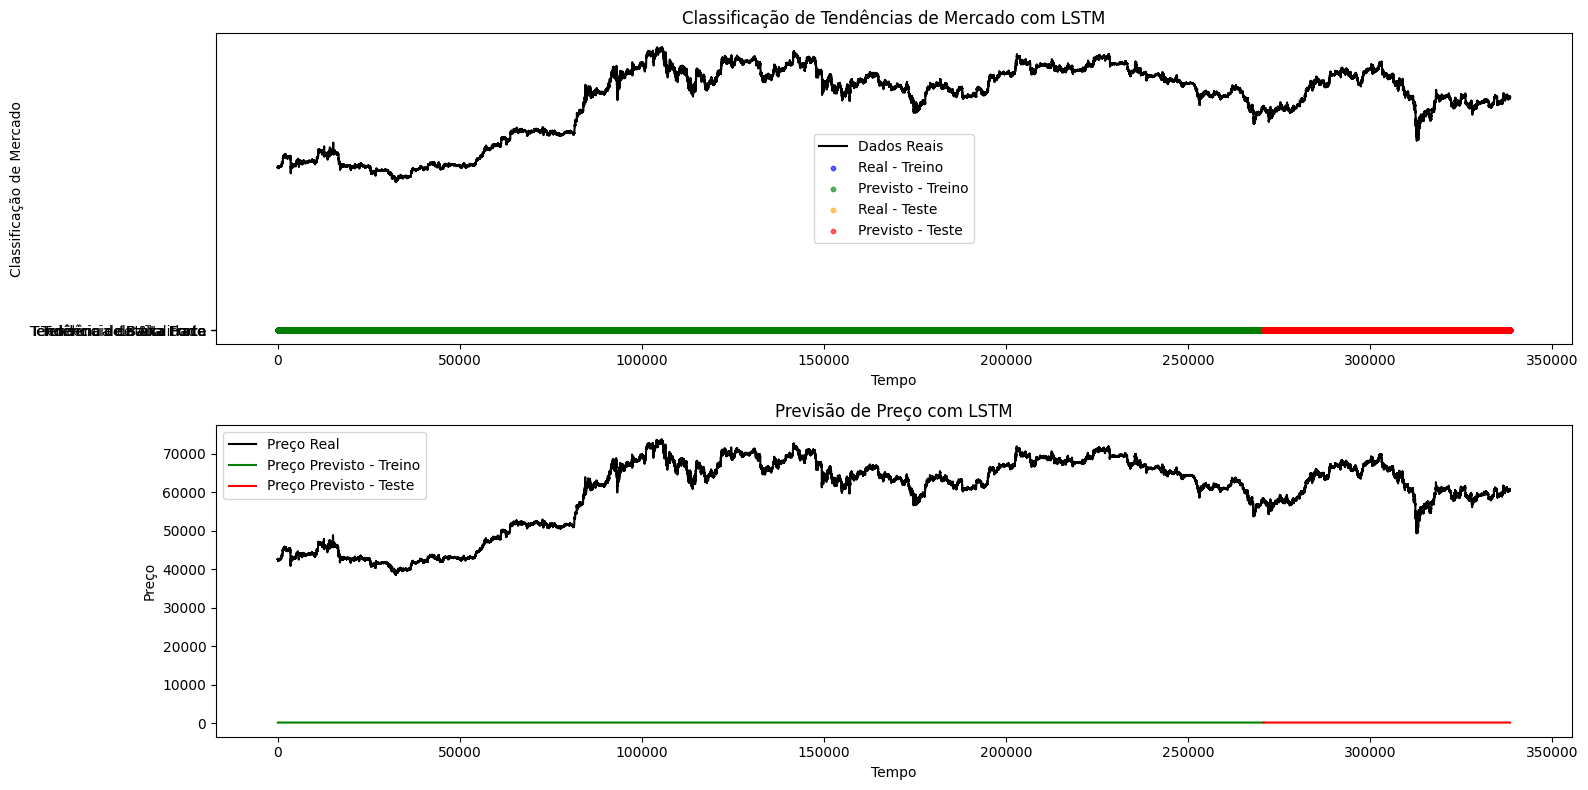

Train Accuracy (Classificação): 0.50
Test Accuracy (Classificação): 0.50
Train Score (Previsão de Preço): 60167.44 RMSE
Test Score (Previsão de Preço): 61527.43 RMSE


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
df = df.dropna()
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()


# Função para preprocessar os dados
def preprocess_data(df, look_back=60, test_size=0.2):
    # Normalizar as colunas relevantes para a previsão
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_df = scaler.fit_transform(df[['open', 'high', 'low', 'close', 'volume', 'MA', 'Deviation']])

    # Codificar as classes em números inteiros para Market_State
    label_encoder = LabelEncoder()
    df['Market_State'] = label_encoder.fit_transform(df['Market_State'])

    # Adicionar a coluna Market_State ao conjunto de features
    scaled_df = np.hstack((scaled_df, df['Market_State'].values.reshape(-1, 1)))

    # Criar conjuntos de dados
    X, y_class, y_price = [], [], []
    for i in range(len(scaled_df) - look_back):
        X.append(scaled_df[i:(i + look_back)])
        y_class.append(df['Market_State'].iloc[i + look_back])
        y_price.append(df['close'].iloc[i + look_back])

    X = np.array(X)
    y_class = to_categorical(np.array(y_class), num_classes=len(label_encoder.classes_))
    y_price = np.array(y_price)

    # Dividir em treino e teste
    X_train, X_test, y_class_train, y_class_test, y_price_train, y_price_test = train_test_split(
        X, y_class, y_price, test_size=test_size, shuffle=False)

    return X_train, X_test, y_class_train, y_class_test, y_price_train, y_price_test, label_encoder, scaler

# Função para criar o modelo LSTM
def create_lstm_model(input_shape, units=50, dropout_rate=0.2, num_classes=5):
    inputs = Input(shape=input_shape)
    x = LSTM(units, return_sequences=True)(inputs)
    x = Dropout(dropout_rate)(x)
    x = LSTM(units, return_sequences=False)(x)
    x = Dropout(dropout_rate)(x)

    # Output 1: Categorização (Classificação)
    out_class = Dense(num_classes, activation='softmax', name='class_output')(x)

    # Concatenar a saída da classificação com a entrada original para a regressão
    concat = Concatenate()([x, out_class])

    # Output 2: Previsão de Preço (Regressão)
    out_price = Dense(1, activation='linear', name='price_output')(concat)

    model = Model(inputs=inputs, outputs=[out_class, out_price])
    model.compile(optimizer='adam',
                  loss={'class_output': 'categorical_crossentropy', 'price_output': 'mean_squared_error'},
                  metrics={'class_output': 'accuracy', 'price_output': 'mse'})
    return model

# Função para treinar e prever usando o modelo
def train_and_predict(df, look_back=60, test_size=0.2, epochs=1, batch_size=64):
    X_train, X_test, y_class_train, y_class_test, y_price_train, y_price_test, label_encoder, scaler = preprocess_data(
        df, look_back, test_size)

    model = create_lstm_model((look_back, X_train.shape[2]), units=50, dropout_rate=0.2, num_classes=y_class_train.shape[1])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train,
                        {'class_output': y_class_train, 'price_output': y_price_train},
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(X_test, {'class_output': y_class_test, 'price_output': y_price_test}),
                        verbose=1, callbacks=[early_stopping])

    y_class_train_pred, y_price_train_pred = model.predict(X_train)
    y_class_test_pred, y_price_test_pred = model.predict(X_test)

    return y_class_train_pred, y_class_test_pred, y_price_train_pred, y_price_test_pred, y_class_train, y_class_test, y_price_train, y_price_test, history, label_encoder, scaler

# Função para plotar os resultados
def plot_results(df, y_class_train_pred, y_class_test_pred, y_price_train_pred, y_price_test_pred,
                 y_class_train, y_class_test, y_price_train, y_price_test, label_encoder, column='close'):
    import matplotlib.pyplot as plt

    # Obter as classes reais e previstas
    y_class_train_real = np.argmax(y_class_train, axis=1)
    y_class_test_real = np.argmax(y_class_test, axis=1)
    y_class_train_pred = np.argmax(y_class_train_pred, axis=1)
    y_class_test_pred = np.argmax(y_class_test_pred, axis=1)

    # Decodificar as classes
    y_class_train_real_decoded = label_encoder.inverse_transform(y_class_train_real)
    y_class_test_real_decoded = label_encoder.inverse_transform(y_class_test_real)
    y_class_train_pred_decoded = label_encoder.inverse_transform(y_class_train_pred)
    y_class_test_pred_decoded = label_encoder.inverse_transform(y_class_test_pred)

    # Plotagem dos resultados
    plt.figure(figsize=(16, 8))

    plt.subplot(2, 1, 1)
    plt.plot(df[column].values, label='Dados Reais', color='black')
    plt.scatter(range(60, 60 + len(y_class_train_real_decoded)), y_class_train_real_decoded, label='Real - Treino', color='blue', alpha=0.6, s=10)
    plt.scatter(range(60, 60 + len(y_class_train_pred_decoded)), y_class_train_pred_decoded, label='Previsto - Treino', color='green', alpha=0.6, s=10)
    plt.scatter(range(60 + len(y_class_train_real_decoded), 60 + len(y_class_train_real_decoded) + len(y_class_test_real_decoded)), y_class_test_real_decoded, label='Real - Teste', color='orange', alpha=0.6, s=10)
    plt.scatter(range(60 + len(y_class_train_real_decoded), 60 + len(y_class_train_real_decoded) + len(y_class_test_pred_decoded)), y_class_test_pred_decoded, label='Previsto - Teste', color='red', alpha=0.6, s=10)
    plt.title('Classificação de Tendências de Mercado com LSTM')
    plt.xlabel('Tempo')
    plt.ylabel('Classificação de Mercado')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(df[column].values[60:], label='Preço Real', color='black')
    plt.plot(range(60, 60 + len(y_price_train_pred)), y_price_train_pred, label='Preço Previsto - Treino', color='green')
    plt.plot(range(60 + len(y_price_train_pred), 60 + len(y_price_train_pred) + len(y_price_test_pred)), y_price_test_pred, label='Preço Previsto - Teste', color='red')
    plt.title('Previsão de Preço com LSTM')
    plt.xlabel('Tempo')
    plt.ylabel('Preço')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Função principal
def main(df, look_back=60, test_size=0.2, epochs=1, batch_size=64):
    y_class_train_pred, y_class_test_pred, y_price_train_pred, y_price_test_pred, \
    y_class_train, y_class_test, y_price_train, y_price_test, history, label_encoder, scaler = train_and_predict(
        df, look_back, test_size, epochs, batch_size)

    # Plotagem automática ao final do treinamento
    plot_results(df, y_class_train_pred, y_class_test_pred, y_price_train_pred, y_price_test_pred,
                 y_class_train, y_class_test, y_price_train, y_price_test, label_encoder)

    # Calcular a acurácia e RMSE
    train_accuracy = np.mean(np.argmax(y_class_train, axis=1) == np.argmax(y_class_train_pred, axis=1))
    test_accuracy = np.mean(np.argmax(y_class_test, axis=1) == np.argmax(y_class_test_pred, axis=1))
    print(f'Train Accuracy (Classificação): {train_accuracy:.2f}')
    print(f'Test Accuracy (Classificação): {test_accuracy:.2f}')

    from sklearn.metrics import mean_squared_error
    train_score = np.sqrt(mean_squared_error(y_price_train, y_price_train_pred))
    test_score = np.sqrt(mean_squared_error(y_price_test, y_price_test_pred))
    print(f'Train Score (Previsão de Preço): {train_score:.2f} RMSE')
    print(f'Test Score (Previsão de Preço): {test_score:.2f} RMSE')

# Exemplo de chamada da função main
if __name__ == "__main__":
    # Substitua `df` pelo seu DataFrame contendo os dados
    # Certifique-se de que o DataFrame tenha as colunas necessárias
    main(df)


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Supondo que 'df' seja o seu DataFrame com dados financeiros
df = df.dropna()
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

# Função para preprocessar os dados
def preprocess_data(df, look_back=10, test_size=0.2):
    # Codificação da coluna 'Market_State'
    label_encoder = LabelEncoder()
    df['Market_State'] = label_encoder.fit_transform(df['Market_State'])

    # Normalizar as colunas 'close' e 'Market_State'
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_df = scaler.fit_transform(df[['close', 'Market_State']])

    # Criar conjuntos de dados
    X, y_price = [], []
    for i in range(look_back, len(scaled_df)):
        X.append(scaled_df[i-look_back:i, :])
        y_price.append(scaled_df[i, 0])  # Apenas 'close'

    X = np.array(X)
    y_price = np.array(y_price)

    # Dividir em treino e teste
    train_size = int(len(X) * (1 - test_size))
    X_train, X_test = X[:train_size], X[train_size:]
    y_price_train, y_price_test = y_price[:train_size], y_price[train_size:]

    return X_train, X_test, y_price_train, y_price_test, scaler

# Criar modelo LSTM
def create_lstm_model(input_shape):
    model = Sequential()

    # Início do formato diamante: aumentar o número de unidades
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))  # Menor quantidade no início
    model.add(Dropout(0.2))

    model.add(LSTM(units=100, return_sequences=True))  # Aumenta para o meio do diamante
    model.add(Dropout(0.2))

    model.add(LSTM(units=50, return_sequences=False))  # Reduz para o final do diamante
    model.add(Dropout(0.2))

    model.add(Dense(units=1))  # Saída final

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Função para treinar e prever usando o modelo
def train_and_predict(df, look_back=10, test_size=0.2, epochs=1, batch_size=64):
    X_train, X_test, y_price_train, y_price_test, scaler = preprocess_data(df, look_back, test_size)

    model = create_lstm_model((look_back, X_train.shape[2]))

    model.fit(X_train, y_price_train, epochs=epochs, batch_size=batch_size, verbose=1)

    y_price_train_pred = model.predict(X_train)
    y_price_test_pred = model.predict(X_test)

    # Desnormalizar apenas a coluna 'close'
    y_price_train_pred = scaler.inverse_transform(np.concatenate([y_price_train_pred, np.zeros_like(y_price_train_pred)], axis=1))[:, 0]
    y_price_test_pred = scaler.inverse_transform(np.concatenate([y_price_test_pred, np.zeros_like(y_price_test_pred)], axis=1))[:, 0]
    y_price_train = scaler.inverse_transform(np.concatenate([y_price_train.reshape(-1, 1), np.zeros_like(y_price_train.reshape(-1, 1))], axis=1))[:, 0]
    y_price_test = scaler.inverse_transform(np.concatenate([y_price_test.reshape(-1, 1), np.zeros_like(y_price_test.reshape(-1, 1))], axis=1))[:, 0]

    return y_price_train_pred, y_price_test_pred, y_price_train, y_price_test, scaler

# Função para plotar os resultados
def plot_results(df, y_price_train_pred, y_price_test_pred, y_price_train, y_price_test, column='close'):
    plt.figure(figsize=(16, 8))

    # Plotagem dos preços reais e previstos para o conjunto de treino
    plt.subplot(2, 1, 1)
    plt.plot(range(len(y_price_train)), y_price_train, label='Preço Real - Treino', color='black')
    plt.plot(range(len(y_price_train)), y_price_train_pred, label='Preço Previsto - Treino', color='green')
    plt.title('Previsão de Preço com LSTM - Treino')
    plt.xlabel('Tempo')
    plt.ylabel('Preço')
    plt.legend()

    # Plotagem dos preços reais e previstos para o conjunto de teste
    plt.subplot(2, 1, 2)
    plt.plot(range(len(y_price_test)), y_price_test, label='Preço Real - Teste', color='black')
    plt.plot(range(len(y_price_test)), y_price_test_pred, label='Preço Previsto - Teste', color='red')
    plt.title('Previsão de Preço com LSTM - Teste')
    plt.xlabel('Tempo')
    plt.ylabel('Preço')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Função principal
def main(df, look_back=10, test_size=0.2, epochs=1, batch_size=64):
    y_price_train_pred, y_price_test_pred, y_price_train, y_price_test, scaler = train_and_predict(
        df, look_back, test_size, epochs, batch_size)

    # Plotagem automática ao final do treinamento
    plot_results(df, y_price_train_pred, y_price_test_pred, y_price_train, y_price_test)

    # Calcular RMSE
    from sklearn.metrics import mean_squared_error
    train_score = np.sqrt(mean_squared_error(y_price_train, y_price_train_pred))
    test_score = np.sqrt(mean_squared_error(y_price_test, y_price_test_pred))
    print(f'Train Score (Previsão de Preço): {train_score:.2f} RMSE')
    print(f'Test Score (Previsão de Preço): {test_score:.2f} RMSE')

# Exemplo de chamada da função main
if __name__ == "__main__":
    # Substitua `df` pelo seu DataFrame contendo os dados
    # Certifique-se de que o DataFrame tenha as colunas necessárias
    main(df)


NameError: name 'df' is not defined

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#espeificar label encoder
from sklearn.preprocessing import LabelEncoder

# Supondo que 'df' seja o seu DataFrame com dados financeiros
df = df.dropna()
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

# Função para preprocessar os dados
def preprocess_data(df, look_back=10, test_size=0.2):
    # Normalizar a coluna 'close'
    label_encoder = LabelEncoder()
    df['Market_State'] = label_encoder.fit_transform(df['Market_State'])
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_df = scaler.fit_transform(df[['close', 'Market_State']])

    # Criar conjuntos de dados
    X, y_price = [], []
    for i in range(look_back, len(scaled_df)):
        X.append(scaled_df[i-look_back:i, 0])
        y_price.append(scaled_df[i, 0])

    X = np.array(X)
    y_price = np.array(y_price)

    # Dividir em treino e teste
    train_size = int(len(X) * (1 - test_size))
    X_train, X_test = X[:train_size], X[train_size:]
    y_price_train, y_price_test = y_price[:train_size], y_price[train_size:]

    # Reshape para [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, X_test, y_price_train, y_price_test, scaler

# Criar modelo LSTM
def create_lstm_model(input_shape):
    model = Sequential()

    # Início do formato diamante: aumentar o número de unidades
    model.add(LSTM(units=20, return_sequences=True, input_shape=input_shape))  # Menor quantidade no início
    model.add(Dropout(0.2))

    model.add(LSTM(units=40, return_sequences=True))  # Aumenta para o meio do diamante
    model.add(Dropout(0.2))

    model.add(LSTM(units=20, return_sequences=False))  # Reduz para o final do diamante
    model.add(Dropout(0.2))

    model.add(Dense(units=1))  # Saída final

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
# Função para treinar e prever usando o modelo
def train_and_predict(df, look_back=10, test_size=0.2, epochs=1, batch_size=64):
    X_train, X_test, y_price_train, y_price_test, scaler = preprocess_data(df, look_back, test_size)

    model = create_lstm_model((look_back, 1))

    model.fit(X_train, y_price_train, epochs=epochs, batch_size=batch_size, verbose=1)

    y_price_train_pred = model.predict(X_train)
    y_price_test_pred = model.predict(X_test)

    y_price_train_pred = scaler.inverse_transform(y_price_train_pred)
    y_price_test_pred = scaler.inverse_transform(y_price_test_pred)
    y_price_train = scaler.inverse_transform(y_price_train.reshape(-1, 1))
    y_price_test = scaler.inverse_transform(y_price_test.reshape(-1, 1))

    return y_price_train_pred, y_price_test_pred, y_price_train, y_price_test, scaler

# Função para plotar os resultados
def plot_results(df, y_price_train_pred, y_price_test_pred, y_price_train, y_price_test, column='close'):
    plt.figure(figsize=(16, 8))

    # Plotagem dos preços reais e previstos para o conjunto de treino
    plt.subplot(2, 1, 1)
    plt.plot(range(len(y_price_train)), y_price_train, label='Preço Real - Treino', color='black')
    plt.plot(range(len(y_price_train)), y_price_train_pred, label='Preço Previsto - Treino', color='green')
    plt.title('Previsão de Preço com LSTM - Treino')
    plt.xlabel('Tempo')
    plt.ylabel('Preço')
    plt.legend()

    # Plotagem dos preços reais e previstos para o conjunto de teste
    plt.subplot(2, 1, 2)
    plt.plot(range(len(y_price_test)), y_price_test, label='Preço Real - Teste', color='black')
    plt.plot(range(len(y_price_test)), y_price_test_pred, label='Preço Previsto - Teste', color='red')
    plt.title('Previsão de Preço com LSTM - Teste')
    plt.xlabel('Tempo')
    plt.ylabel('Preço')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Função principal
def main(df, look_back=10, test_size=0.2, epochs=1, batch_size=64):
    y_price_train_pred, y_price_test_pred, y_price_train, y_price_test, scaler = train_and_predict(
        df, look_back, test_size, epochs, batch_size)

    # Plotagem automática ao final do treinamento
    plot_results(df, y_price_train_pred, y_price_test_pred, y_price_train, y_price_test)

    # Calcular RMSE
    from sklearn.metrics import mean_squared_error
    train_score = np.sqrt(mean_squared_error(y_price_train, y_price_train_pred))
    test_score = np.sqrt(mean_squared_error(y_price_test, y_price_test_pred))
    print(f'Train Score (Previsão de Preço): {train_score:.2f} RMSE')
    print(f'Test Score (Previsão de Preço): {test_score:.2f} RMSE')

# Exemplo de chamada da função main
if __name__ == "__main__":
    # Substitua `df` pelo seu DataFrame contendo os dados
    # Certifique-se de que o DataFrame tenha as colunas necessárias
    main(df)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4231/4231 ━━━━━━━━━━━━━━━━━━━━ 92s 21ms/step - loss: 0.0103
8462/8462 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step


ValueError: non-broadcastable output operand with shape (270774,1) doesn't match the broadcast shape (270774,2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8462/8462 ━━━━━━━━━━━━━━━━━━━━ 121s 14ms/step - loss: 0.0073
8462/8462 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━

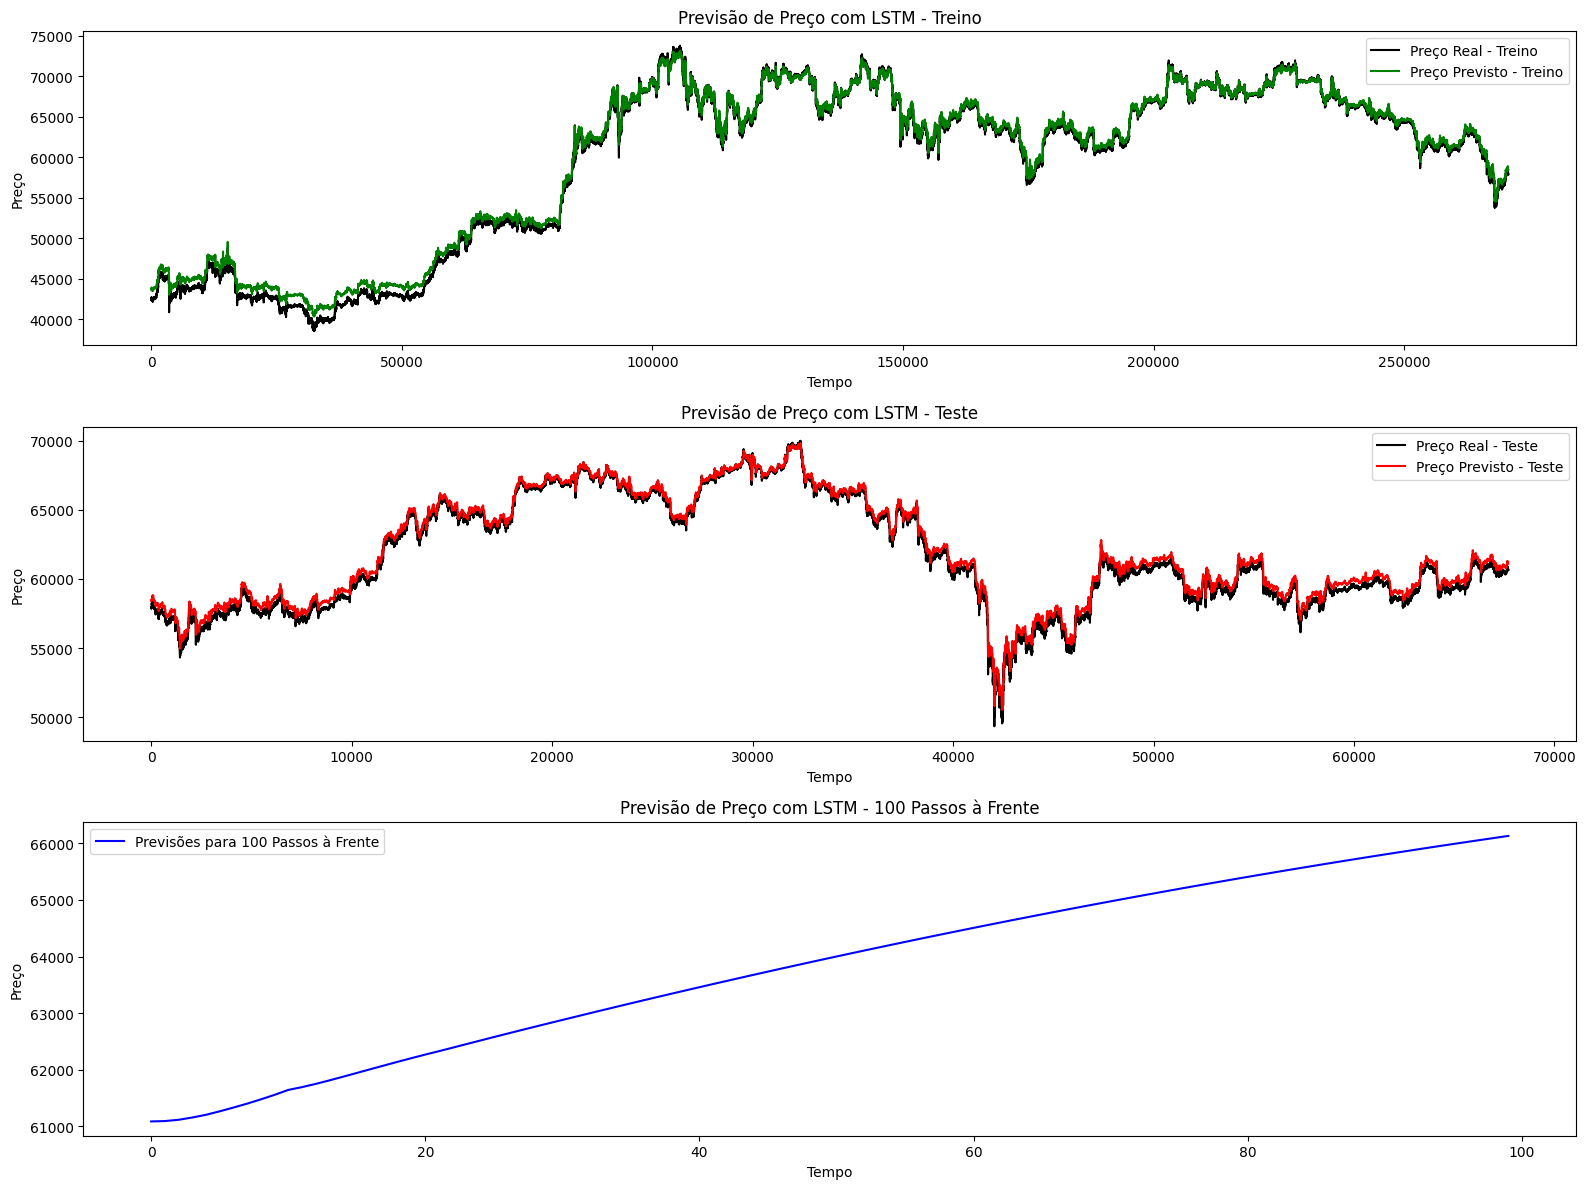

Train Score (Previsão de Preço): 651.10 RMSE
Test Score (Previsão de Preço): 414.83 RMSE


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def preprocess_data(df, look_back=10, test_size=0.2):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_df = scaler.fit_transform(df[['close']])

    X, y_price = [], []
    for i in range(look_back, len(scaled_df)):
        X.append(scaled_df[i-look_back:i, 0])
        y_price.append(scaled_df[i, 0])

    X, y_price = np.array(X), np.array(y_price)

    train_size = int(len(X) * (1 - test_size))
    X_train, X_test = X[:train_size], X[train_size:]
    y_price_train, y_price_test = y_price[:train_size], y_price[train_size:]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, X_test, y_price_train, y_price_test, scaler

def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(units=20, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=40, return_sequences=True),
        Dropout(0.2),
        LSTM(units=20, return_sequences=False),
        Dropout(0.2),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_and_predict(df, look_back=10, test_size=0.2, epochs=50, batch_size=32):
    X_train, X_test, y_price_train, y_price_test, scaler = preprocess_data(df, look_back, test_size)

    model = create_lstm_model((look_back, 1))
    model.fit(X_train, y_price_train, epochs=epochs, batch_size=batch_size, verbose=1)

    y_price_train_pred = model.predict(X_train)
    y_price_test_pred = model.predict(X_test)

    # Fazer previsões para 100 passos à frente
    last_sequence = X_test[-1]
    future_predictions = []
    for _ in range(100):
        next_pred = model.predict(last_sequence.reshape(1, look_back, 1))
        future_predictions.append(next_pred[0, 0])
        last_sequence = np.roll(last_sequence, -1)
        last_sequence[-1] = next_pred

    return y_price_train_pred, y_price_test_pred, y_price_train, y_price_test, np.array(future_predictions), scaler

def plot_predictions(y_price_train, y_price_train_pred, y_price_test, y_price_test_pred, future_predictions, scaler):
    plt.figure(figsize=(16, 12))

    # Desnormalizar os dados
    y_price_train = scaler.inverse_transform(y_price_train.reshape(-1, 1)).flatten()
    y_price_train_pred = scaler.inverse_transform(y_price_train_pred).flatten()
    y_price_test = scaler.inverse_transform(y_price_test.reshape(-1, 1)).flatten()
    y_price_test_pred = scaler.inverse_transform(y_price_test_pred).flatten()
    future_predictions = scaler.inverse_transform(future_predictions.reshape(-1, 1)).flatten()

    # Plotagem dos preços reais e previstos para o conjunto de treino
    plt.subplot(3, 1, 1)
    plt.plot(y_price_train, label='Preço Real - Treino', color='black')
    plt.plot(y_price_train_pred, label='Preço Previsto - Treino', color='green')
    plt.title('Previsão de Preço com LSTM - Treino')
    plt.xlabel('Tempo')
    plt.ylabel('Preço')
    plt.legend()

    # Plotagem dos preços reais e previstos para o conjunto de teste
    plt.subplot(3, 1, 2)
    plt.plot(y_price_test, label='Preço Real - Teste', color='black')
    plt.plot(y_price_test_pred, label='Preço Previsto - Teste', color='red')
    plt.title('Previsão de Preço com LSTM - Teste')
    plt.xlabel('Tempo')
    plt.ylabel('Preço')
    plt.legend()

    # Plotagem das previsões para 100 passos à frente
    plt.subplot(3, 1, 3)
    plt.plot(range(len(future_predictions)), future_predictions, label='Previsões para 100 Passos à Frente', color='blue')
    plt.title('Previsão de Preço com LSTM - 100 Passos à Frente')
    plt.xlabel('Tempo')
    plt.ylabel('Preço')
    plt.legend()

    plt.tight_layout()
    plt.show()

def main(df, look_back=10, test_size=0.2, epochs=1, batch_size=32):
    y_price_train_pred, y_price_test_pred, y_price_train, y_price_test, future_predictions, scaler = train_and_predict(
        df, look_back, test_size, epochs, batch_size)

    plot_predictions(y_price_train, y_price_train_pred, y_price_test, y_price_test_pred, future_predictions, scaler)

    # Calcular RMSE
    train_score = np.sqrt(mean_squared_error(scaler.inverse_transform(y_price_train.reshape(-1, 1)),
                                             scaler.inverse_transform(y_price_train_pred)))
    test_score = np.sqrt(mean_squared_error(scaler.inverse_transform(y_price_test.reshape(-1, 1)),
                                            scaler.inverse_transform(y_price_test_pred)))
    print(f'Train Score (Previsão de Preço): {train_score:.2f} RMSE')
    print(f'Test Score (Previsão de Preço): {test_score:.2f} RMSE')

if __name__ == "__main__":
    # Criando um DataFrame de exemplo

    main(df)

In [ ]:
import numpy as np

# Função para calcular a profundidade e as camadas conforme as diretrizes de Hanin
def calculate_layers(input_size, output_size, initial_units=64, depth=3, reduction_factor=2):
    layers = []

    # Definindo o número de unidades da primeira camada
    units = initial_units
    for i in range(depth):
        layers.append(units)
        units = max(units // reduction_factor, output_size)

    return layers

# Função para calcular o número de parâmetros N
def calculate_parameters(layers, input_size, output_size):
    total_params = 0

    # Calcula os parâmetros da camada de entrada para a primeira camada oculta
    total_params += input_size * layers[0] + layers[0]  # Pesos + Bias

    # Calcula os parâmetros entre camadas ocultas
    for i in range(1, len(layers)):
        total_params += layers[i-1] * layers[i] + layers[i]  # Pesos + Bias

    # Calcula os parâmetros da última camada oculta para a saída
    total_params += layers[-1] * output_size + output_size  # Pesos + Bias

    return total_params

# Parâmetros da rede conforme Hanin
input_size = 5  # Supondo que temos 5 features
output_size = 1  # Saída única para prever o preço de fechamento
initial_units = 64  # Número de unidades na primeira camada
depth = 3  # Número de camadas da rede
reduction_factor = 2  # Fator de redução do número de unidades por camada

# Calculando as camadas
layers = calculate_layers(input_size, output_size, initial_units, depth, reduction_factor)

# Calculando o número de parâmetros
total_params = calculate_parameters(layers, input_size, output_size)

# Calculando L/N
L_N_ratio = depth / total_params

# Exibindo os resultados
print("Camadas da Rede Neural:")
for i, units in enumerate(layers):
    print(f"Camada {i+1}: {units} unidades")

print(f"\nProfundidade (L): {depth}")
print(f"Número total de parâmetros (N): {total_params}")
print(f"Relação L/N: {L_N_ratio:.10f}")


In [ ]:
import numpy as np

# Função para calcular a profundidade e as camadas conforme as diretrizes de Hanin
def calculate_layers(input_size, output_size, initial_units=64, reduction_factor=2):
    layers = []
    units = initial_units
    while True:
        layers.append(units)
        units = max(units // reduction_factor, output_size)
        if units == output_size:
            break
    return layers

# Função para calcular o número de parâmetros N
def calculate_parameters(layers, input_size, output_size):
    total_params = 0

    # Calcula os parâmetros da camada de entrada para a primeira camada oculta
    total_params += input_size * layers[0] + layers[0]  # Pesos + Bias

    # Calcula os parâmetros entre camadas ocultas
    for i in range(1, len(layers)):
        total_params += layers[i-1] * layers[i] + layers[i]  # Pesos + Bias

    # Calcula os parâmetros da última camada oculta para a saída
    total_params += layers[-1] * output_size + output_size  # Pesos + Bias

    return total_params

# Função para ajustar a profundidade para atingir a relação L/N desejada
def adjust_layers_for_ln_ratio(input_size, output_size, desired_ln_ratio=0.3, initial_units=64, reduction_factor=2):
    depth = 1  # Começamos com uma profundidade mínima de 1
    while True:
        layers = calculate_layers(input_size, output_size, initial_units, reduction_factor)
        total_params = calculate_parameters(layers, input_size, output_size)
        ln_ratio = depth / total_params

        if ln_ratio >= desired_ln_ratio:
            break

        depth += 1  # Aumenta a profundidade da rede
        initial_units = max(2, initial_units // reduction_factor)  # Opcional: reduzir as unidades para evitar grandes N

    return layers, depth, total_params, ln_ratio

# Parâmetros da rede conforme Hanin
input_size = 5  # Supondo que temos 5 features
output_size = 1  # Saída única para prever o preço de fechamento
desired_ln_ratio = 0.3  # Relação L/N desejada

# Ajustar as camadas para atingir a relação L/N desejada
layers, depth, total_params, ln_ratio = adjust_layers_for_ln_ratio(input_size, output_size, desired_ln_ratio)

# Exibindo os resultados
print("Camadas da Rede Neural:")
for i, units in enumerate(layers):
    print(f"Camada {i+1}: {units} unidades")

print(f"\nProfundidade (L): {depth}")
print(f"Número total de parâmetros (N): {total_params}")
print(f"Relação L/N: {ln_ratio:.10f}")
